In [1]:
import os
import cv2
import numpy as np
import pywt
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# === Haar Cascade Classifiers ===
face_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_eye.xml')

In [3]:
# === Wavelet Transform Function ===
def w2d(img, mode='haar', level=1):
    imArray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    imArray = np.float32(imArray)
    imArray /= 255
    coeffs = pywt.wavedec2(imArray, mode, level=level)
    coeffs_H = list(coeffs)
    coeffs_H[0] *= 0
    imArray_H = pywt.waverec2(coeffs_H, mode)
    imArray_H *= 255
    imArray_H = np.uint8(imArray_H)
    return imArray_H

In [4]:
# === Face and Eye Detector ===
def get_cropped_image_if_2_eyes(image_path):
    img = cv2.imread(image_path)
    if img is None:
        return None
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x, y, w, h) in faces:
        roi_gray = gray[y:y + h, x:x + w]
        roi_color = img[y:y + h, x:x + w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) >= 2:
            return roi_color
    return None


In [5]:
# === Paths ===
path_to_data = "athletes_dataset_4"
path_to_cr_data = os.path.join(path_to_data, "cropped")

# === Collect image directories ===
img_dirs = [entry.path for entry in os.scandir(path_to_data) if entry.is_dir()]

# === Clear cropped directory if it exists ===
import shutil
if os.path.exists(path_to_cr_data):
    shutil.rmtree(path_to_cr_data)
os.makedirs(path_to_cr_data)

In [6]:
# === Crop and Save Valid Face Images ===
cropped_image_dirs = []
celebrity_file_names_dict = {}

for img_dir in img_dirs:
    count = 1
    celebrity_name = os.path.basename(img_dir)
    celebrity_file_names_dict[celebrity_name] = []

    for entry in os.scandir(img_dir):
        if entry.is_file() and entry.name.lower().endswith(('.jpg', '.jpeg', '.png')):
            roi_color = get_cropped_image_if_2_eyes(entry.path)

            if roi_color is not None:
                cropped_folder = os.path.join(path_to_cr_data, celebrity_name)

                if not os.path.exists(cropped_folder):
                    os.makedirs(cropped_folder)
                    cropped_image_dirs.append(cropped_folder)
                    print(" Generating cropped images in folder:", cropped_folder)

                cropped_file_name = f"{celebrity_name}{count}.png"
                cropped_file_path = os.path.join(cropped_folder, cropped_file_name)

                cv2.imwrite(cropped_file_path, roi_color)
                celebrity_file_names_dict[celebrity_name].append(cropped_file_path)
                count += 1


 Generating cropped images in folder: athletes_dataset_4\cropped\Allyson_Felix
 Generating cropped images in folder: athletes_dataset_4\cropped\Anthony_Davis
 Generating cropped images in folder: athletes_dataset_4\cropped\Antoine_Griezmann
 Generating cropped images in folder: athletes_dataset_4\cropped\Aryna_Sabalenka
 Generating cropped images in folder: athletes_dataset_4\cropped\Babar_Azam
 Generating cropped images in folder: athletes_dataset_4\cropped\Ben_Stokes
 Generating cropped images in folder: athletes_dataset_4\cropped\Carlos_Alcaraz
 Generating cropped images in folder: athletes_dataset_4\cropped\Carl_Lewis
 Generating cropped images in folder: athletes_dataset_4\cropped\Coco_Gauff
 Generating cropped images in folder: athletes_dataset_4\cropped\Cristiano_Ronaldo
 Generating cropped images in folder: athletes_dataset_4\cropped\Daniil_Medvedev
 Generating cropped images in folder: athletes_dataset_4\cropped\Elaine_Thompson-Herah
 Generating cropped images in folder: athle

In [24]:
# === Double Check: Print cropped_image_dirs ===
#print("\n Final cropped_image_dirs:")
#for folder in cropped_image_dirs:
#    print(folder, "→", os.listdir(folder))

# === Check loaded file lists from cropped folders ===
print("\n Verifying files per celebrity:")
for celeb, files in celebrity_file_names_dict.items():
    print(f"{celeb}: {len(files)} files")



 Verifying files per celebrity:
Aryna_Sabalenka: 57 files
Cristiano_Ronaldo: 64 files
Giannis_Antetokounmpo: 57 files
Hardik_Pandya: 62 files
Karim_Benzema: 50 files
Neymar_Jr: 50 files
Paulo_Dybala: 51 files
Robert_Lewandowski: 60 files
Sachin_Tendulkar: 54 files
Stephen_Curry: 56 files
Sydney_McLaughlin: 58 files
Virgil_van_Dijk: 55 files


In [16]:
# === Filter out classes with fewer than N images ===
min_images = 50
filtered_celebrity_file_names_dict = {
    celeb: files
    for celeb, files in celebrity_file_names_dict.items()
    if len(files) >= min_images
}

print(f"\nAfter filtering, {len(filtered_celebrity_file_names_dict)} classes kept out of {len(celebrity_file_names_dict)}")

# Update downstream variables
celebrity_file_names_dict = filtered_celebrity_file_names_dict
class_dict = {name: idx for idx, name in enumerate(celebrity_file_names_dict.keys())}



After filtering, 12 classes kept out of 29


In [17]:

# === Prepare Feature Matrix (X) and Labels (y) ===
X, y = [], []
for celebrity_name, training_files in celebrity_file_names_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        scalled_raw_img = cv2.resize(img, (32, 32))
        img_har = w2d(img, 'db1', 5)
        scalled_img_har = cv2.resize(img_har, (32, 32))
        combined_img = np.vstack((
            scalled_raw_img.reshape(32 * 32 * 3, 1),
            scalled_img_har.reshape(32 * 32, 1)
        ))
        X.append(combined_img)
        y.append(class_dict[celebrity_name])

X = np.array(X).reshape(len(X), 4096).astype(float)
y = np.array(y)


In [18]:
# === Train/Test Split and Classifier ===
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(kernel='rbf', C=10))
])
pipe.fit(X_train, y_train)

print("\nAccuracy:", pipe.score(X_test, y_test))
print(classification_report(y_test, pipe.predict(X_test)))



Accuracy: 0.6627218934911243
              precision    recall  f1-score   support

           0       0.62      0.44      0.52        18
           1       0.63      0.86      0.73        14
           2       0.69      0.85      0.76        13
           3       0.46      0.85      0.59        13
           4       0.90      0.60      0.72        15
           5       0.38      0.25      0.30        12
           6       0.83      0.50      0.62        10
           7       0.81      0.72      0.76        18
           8       0.72      0.76      0.74        17
           9       0.78      0.50      0.61        14
          10       0.53      1.00      0.69         9
          11       0.85      0.69      0.76        16

    accuracy                           0.66       169
   macro avg       0.68      0.67      0.65       169
weighted avg       0.69      0.66      0.66       169



In [19]:
# === GridSearchCV for Best Model ===
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
import pandas as pd

model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto', probability=True),
        'params': {
            'svc__C': [1, 10, 100],
            'svc__kernel': ['rbf', 'linear']
        }
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params': {
            'randomforestclassifier__n_estimators': [5, 10]
        }
    },
    'logistic_regression': {
        'model': LogisticRegression(solver='liblinear', multi_class='auto'),
        'params': {
            'logisticregression__C': [1, 5, 10]
        }
    }
}



In [20]:
scores = []
best_estimators = {}

for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf = GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_

df = pd.DataFrame(scores, columns=['model', 'best_score', 'best_params'])
print("\n Model Comparison:\n", df)


C:\Users\Neeli\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\Neeli\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\Neeli\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\Neeli\AppData\Local\Programs\Python\P


 Model Comparison:
                  model  best_score  \
0                  svm    0.669307   
1        random_forest    0.368317   
2  logistic_regression    0.659406   

                                    best_params  
0        {'svc__C': 1, 'svc__kernel': 'linear'}  
1  {'randomforestclassifier__n_estimators': 10}  
2                  {'logisticregression__C': 1}  


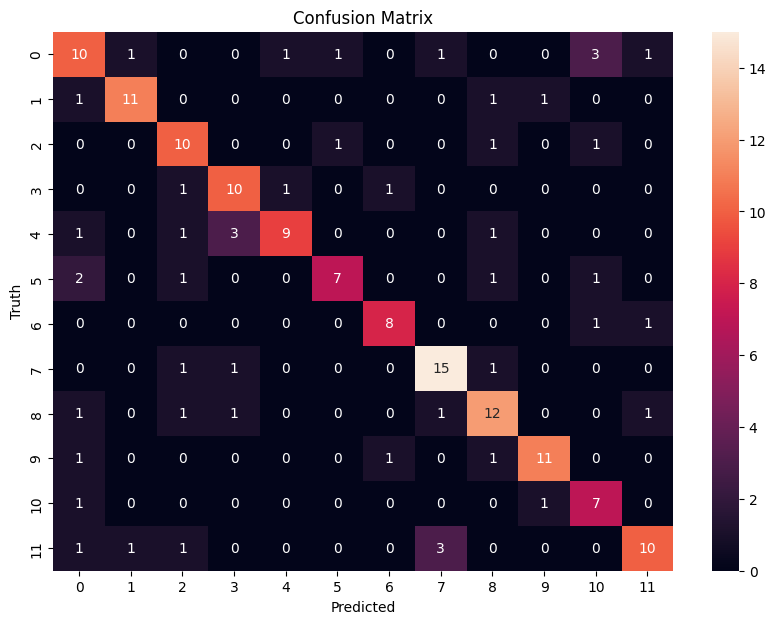

In [21]:
# === Confusion Matrix ===
from sklearn.metrics import confusion_matrix
import seaborn as sn

best_clf = best_estimators['svm']
cm = confusion_matrix(y_test, best_clf.predict(X_test))

plt.figure(figsize=(10, 7))
sn.heatmap(cm, annot=True)
plt.xlabel("Predicted")
plt.ylabel("Truth")
plt.title("Confusion Matrix")
plt.show()

In [22]:
# === Save the Model and Class Dictionary ===
import joblib
joblib.dump(best_clf, 'saved_model.pkl')

import json
with open("class_dictionary.json", "w") as f:
    json.dump(class_dict, f)

print("\n Model and class dictionary saved.")



 Model and class dictionary saved.
